In [1]:
import math
import os.path
import csv
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
window_size = 48
stock_scaler = MinMaxScaler()
sentiment_scaler = MinMaxScaler(feature_range=(-1, 1))
def prepare_input_data(X, Z, price_to_sentiment, window_size):
    X_train, y_train = [], []
    for i in range(window_size, len(X)):
        x_slice = np.array(X[i-window_size:i])
        # x_slice = np.zeros(window_size)
        index = price_to_sentiment[i]
        Z=np.array(Z)
        z_slice = Z[max(0, index-(window_size-1)):index+1, :]
        if z_slice.shape[0] < window_size:
            num_rows_to_pad = window_size - z_slice.shape[0]
            pad_width = ((num_rows_to_pad, 0), (0, 0))
            z_slice = np.pad(z_slice, pad_width, mode='constant', constant_values=0)
        X_train.append(np.hstack((x_slice.reshape(-1, 1), z_slice)))
        y_train.append(X[i])
    return np.array(X_train), np.array(y_train)

In [3]:
def load_data(price_file, sentiment_file):
    price = []
    price_time = []
    with open(price_file, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            price.append(float(row["close-price"]))
            price_time.append(row["datetime"])
    sentiment = []
    sentiment_time = []
    with open(sentiment_file, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            sentiment.append([float(row["updated_positive"]), float(row["updated_negative"]), float(row["positive_fintech"]), float(row["negative_fintech"])])
            sentiment_time.append(row["datetime"])
    price_to_sentiment = []
    for time in price_time:
        time_pre_hour = (datetime.strptime(time, "%Y-%m-%d %H:%M") - timedelta(hours=1)).strftime("%Y-%m-%d %H")
        if time_pre_hour in sentiment_time:
            price_to_sentiment.append(sentiment_time.index(time_pre_hour))
        else:
            price_to_sentiment.append(-1)
    price = stock_scaler.fit_transform(np.array(price).reshape(-1, 1))
    sentiment = sentiment_scaler.fit_transform(sentiment)
    # price = np.array(price).reshape(-1, 1)
    return price, sentiment, price_to_sentiment

In [4]:
folder = os.path.join("data_sentiment_score", "gme")
price_file = os.path.join(folder, "price.csv")
sentiment_file = os.path.join(folder, "gme_all.csv")
price, sentiment, price_to_sentiment = load_data(price_file, sentiment_file)
x1, y1 = prepare_input_data(price, sentiment, price_to_sentiment, window_size)

In [5]:
folder = os.path.join("data_sentiment_score", "netflix")
price_file = os.path.join(folder, "price.csv")
sentiment_file = os.path.join(folder, "netflix.csv")
price, sentiment, price_to_sentiment = load_data(price_file, sentiment_file)
x2, y2 = prepare_input_data(price, sentiment, price_to_sentiment, window_size)

In [6]:
folder = os.path.join("data_sentiment_score", "nvidia")
price_file = os.path.join(folder, "price.csv")
sentiment_file = os.path.join(folder, "nvidia.csv")
price, sentiment, price_to_sentiment = load_data(price_file, sentiment_file)
x3 ,y3 = prepare_input_data(price, sentiment, price_to_sentiment, window_size)

In [7]:
folder = os.path.join("data_sentiment_score", "tesla")
price_file = os.path.join(folder, "price.csv")
sentiment_file = os.path.join(folder, "tesla.csv")
price, sentiment, price_to_sentiment = load_data(price_file, sentiment_file)
x4, y4 = prepare_input_data(price, sentiment, price_to_sentiment, window_size)

In [8]:
all_x = np.concatenate((x1,x2,x3,x4), axis=0)
all_y = np.concatenate((y1,y2,y3,y4), axis=0)

print(all_x.shape)
print(all_y.shape)

(2945, 48, 5)
(2945, 1)


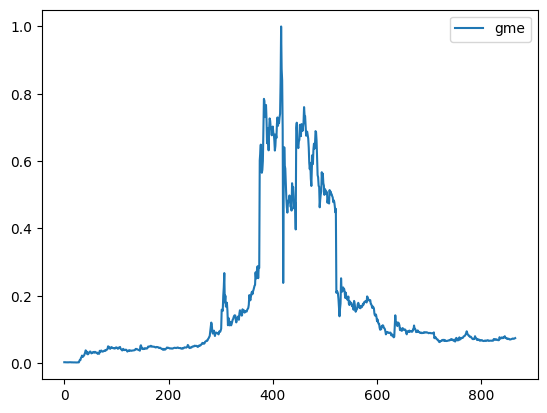

In [39]:
plt.plot(y1, label='gme')
plt.legend()
plt.show()

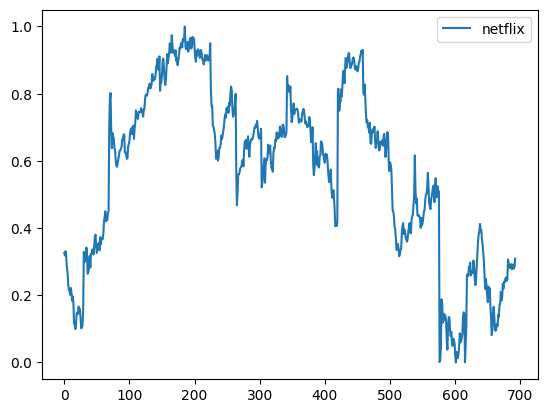

In [40]:
plt.plot(y2, label='netflix')
plt.legend()
plt.show()

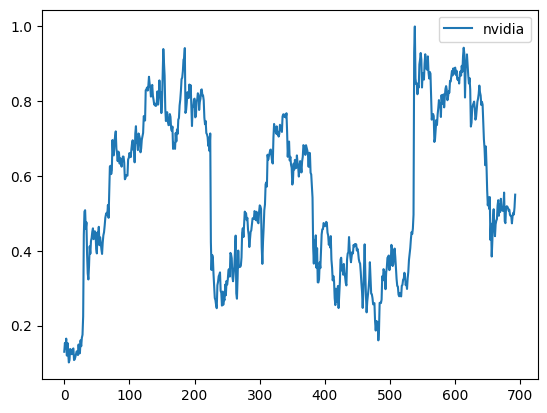

In [41]:
plt.plot(y3, label='nvidia')
plt.legend()
plt.show()

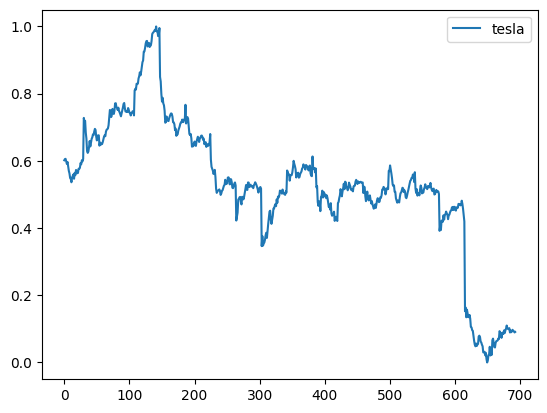

In [42]:
plt.plot(y4, label='tesla')
plt.legend()
plt.show()

In [65]:
# X_train, X_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.1, shuffle=False)

In [42]:
X_train = np.concatenate((x3,x4, x1), axis=0)
y_train = np.concatenate((y3,y4, y1), axis=0)
X_test = x2
y_test = y2
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.0001, shuffle=True)

In [43]:
model = Sequential()
model.add(LSTM(units=256, return_sequences = True, input_shape=(window_size, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 48))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40
71/71 [==============================] - 20s 154ms/step - loss: 0.0199 - val_loss: 0.0136
Epoch 2/40
71/71 [==============================] - 10s 141ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 3/40
71/71 [==============================] - 10s 142ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 4/40
71/71 [==============================] - 10s 138ms/step - loss: 0.0075 - val_loss: 0.0124
Epoch 5/40
71/71 [==============================] - 10s 139ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 6/40
71/71 [==============================] - 10s 144ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 7/40
71/71 [==============================] - 10s 137ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 8/40
71/71 [==============================] - 10s 139ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 9/40
71/71 [==============================] - 10s 137ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 10/40
71/71 [==============================] - 10s 137ms/step - loss: 0.0044 - val_lo

65/65 [==============================] - 5s 52ms/step


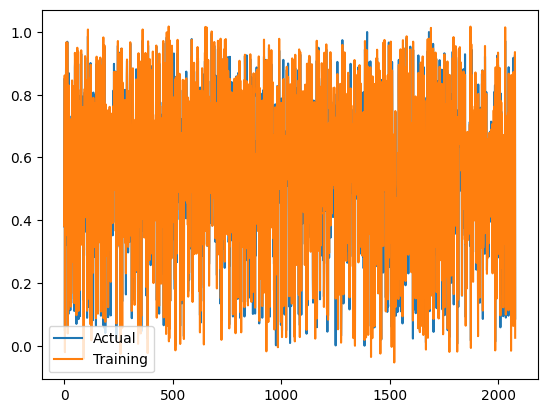

In [46]:
y_pred = model.predict(X_train)

# Plot the actual y_test values against the predicted values
plt.plot(y_train, label='Actual')
plt.plot(y_pred, label='Training')
plt.legend()
plt.show()

In [20]:
y_pred = model.predict(X_test)
# plt.plot(y_test, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

22/22 [==============================] - 3s 63ms/step


In [21]:
def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true-y_pred) / (y_true+0.1)))*100
    return mape

def calculate_da(X_test, y_true, y_pred):
    """
    Calculate the Directional Accuracy
    """
    count = 0
    for i in range(X_test.shape[0]):
        if (y_true[i][0]>X_test[i][-1][0] and y_pred[i][0]>X_test[i][-1][0]) or (y_true[i][0]<X_test[i][-1][0] and y_pred[i][0]<X_test[i][-1][0]):
            count+=1
    return count/X_test.shape[0]

In [22]:
calculate_mape(y_test, y_pred)

3.715832834606841

In [23]:
calculate_da(X_test, y_test, y_pred)

0.5021645021645021

In [39]:
calculate_mape(y3[:-2], y3[2:])

6.281774432590681

In [25]:
def predict_period(X_test, y_test):
    y_pred = []
    X_test_temp = X_test.copy()
    y_pre = model.predict(X_test_temp[0, :, :].reshape(1, window_size, 5))
    y_pred.append(y_pre[0][0])
    for i in range(1, len(X_test_temp)):
        X_test_temp[i, :-1, 0] = X_test_temp[i-1, 1:, 0]
        X_test_temp[i, -1, 0] = y_pre
        y_pre = model.predict(X_test_temp[i, :, :].reshape(1, window_size, 5))
        y_pred.append(y_pre[0][0])

    # y_pred = model.predict(X_test)
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

In [26]:
def predict_per_day(X_test):
    y_pred = []
    X_test_temp = X_test.copy()
    for i in range(len(X_test_temp)):
        if i%39 != 0:
            X_test_temp[i, :-1, 0] = X_test_temp[i-1, 1:, 0]
            X_test_temp[i, -1, 0] = y_pre
        y_pre = model.predict(X_test_temp[i, :, :].reshape(1, window_size, 5))
        y_pred.append(y_pre[0][0])
    return y_pred

In [29]:
# y_pred = predict_per_day(x1)
# plt.plot(y1, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

In [30]:
# predict_period(x1,y1)

1/1 [==============================] - 0s 29ms/step


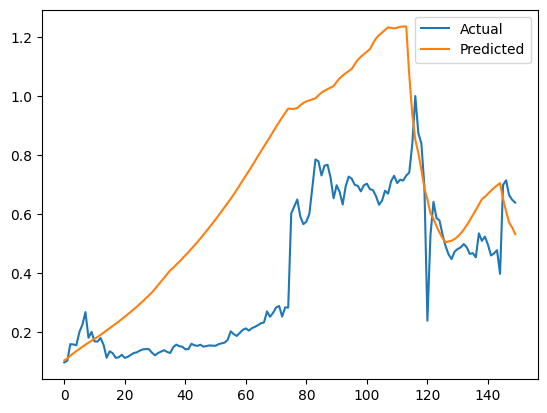

In [143]:
predict_period(x1[300:450], y1[300:450])

1/1 [==============================] - 0s 29ms/step


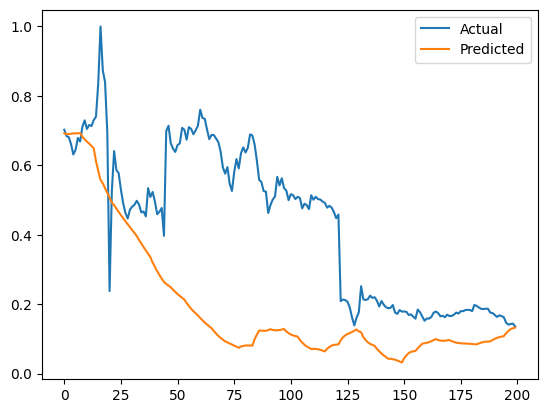

In [129]:
predict_period(x1[400:600], y1[400:600])

1/1 [==============================] - 0s 31ms/step


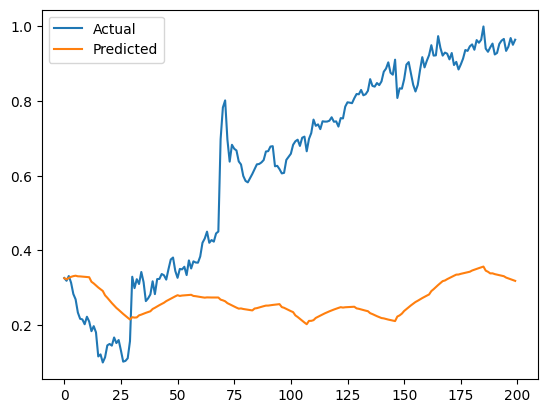

In [45]:
predict_period(x2[:200], y2[:200])

1/1 [==============================] - 0s 36ms/step


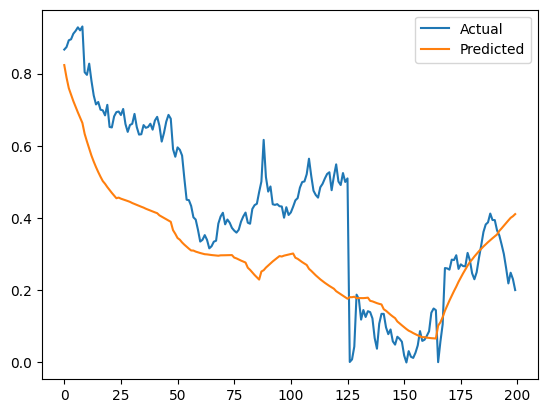

In [46]:
predict_period(x2[450:650], y2[450:650])

1/1 [==============================] - 0s 29ms/step


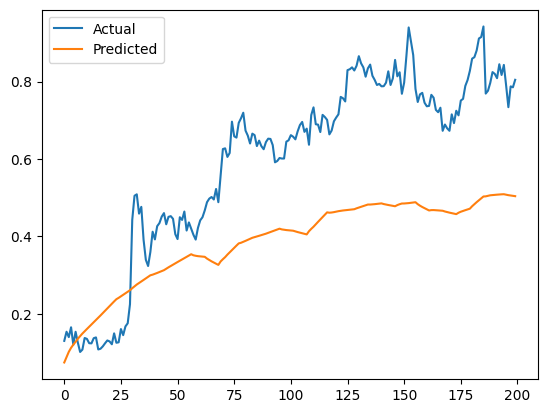

In [111]:
predict_period(x3[:200], y3[:200])

1/1 [==============================] - 0s 37ms/step


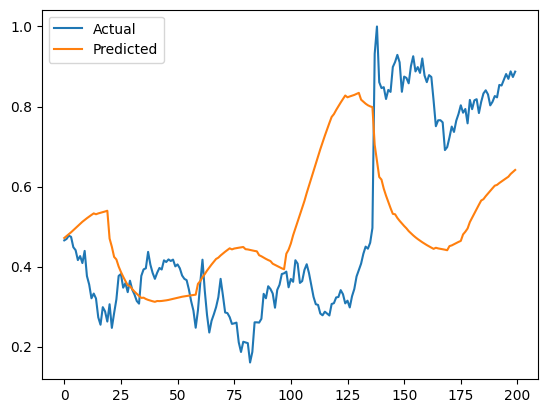

In [34]:
predict_period(x3[400:600], y3[400:600])

1/1 [==============================] - 0s 37ms/step


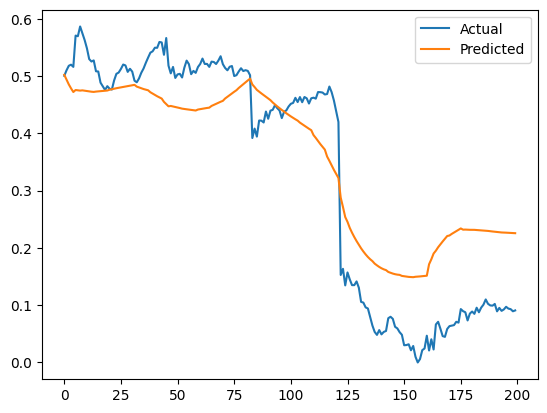

In [28]:
predict_period(x4[-200:], y4[-200:])